Test cross section modification with interpolation of intermediate bins for MCEq. The cross section is modifed at 3 nergies Ea, Eb, Ec and with factors a, b, c

In [2]:
import click
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
from tqdm import tqdm
from MCEq.core import MCEqRun
import mceq_config as config
import crflux.models as pm
from MCEq.data import InteractionCrossSections
import sys
import os
import pickle

from scipy.interpolate import splrep,splev

In [7]:

interactionmodel = "SIBYLL23C"
mceq_def = MCEqRun(
            interaction_model=interactionmodel,
            theta_deg=0.0,
            primary_model=(pm.HillasGaisser2012, "H3a"),
            density_model = (('MSIS00_IC',('SouthPole','January')))
        )

mceq_tune = MCEqRun(
            interaction_model=interactionmodel,
            theta_deg=0.0,
            primary_model=(pm.HillasGaisser2012, "H3a"),
            density_model = (('MSIS00_IC',('SouthPole','January')))
        )



MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [8]:
cs_def = InteractionCrossSections(mceq_def._mceq_db, interaction_model=interactionmodel).get_cs(211, mbarn=True)

In [9]:
E = mceq_def.e_grid

In [10]:
a = 0.05
b =0.1
c =0.1

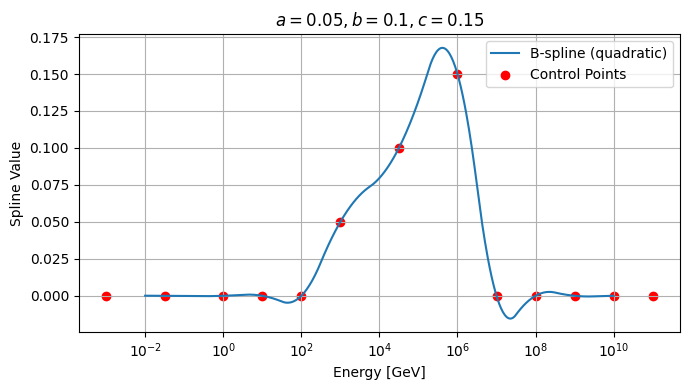

In [11]:
e_grid = np.logspace(-2, 10, 500)  # Energy from 1e2 to 1e7 GeV
log_e_grid = np.log10(e_grid)

# Define 3 control points (in log10(E))
x_knots = np.array([-3, -1.5, 0., 1., 2., 3.0, 4.5, 6.0,7.,8., 9., 10., 11])         # log10(E) values (e.g. 1e3, 3e4, 1e6)
y_knots = np.array([0., 0., 0.,0., 0.,0.05, 0.1, 0.15,0., 0., 0., 0., 0.])        # Values at the control points

# Fit a quadratic B-spline (k=2), with s=0 to interpolate exactly
tck = splrep(x_knots, y_knots, k=2, s=0)

# Evaluate the spline at all grid points
y_spline = splev(log_e_grid, tck)

# Plot
plt.figure(figsize=(7, 4))
plt.plot(e_grid, y_spline, label='B-spline (quadratic)')
plt.scatter(10**x_knots, y_knots, color='red', label='Control Points')
plt.xscale('log')
plt.xlabel('Energy [GeV]')
plt.ylabel('Spline Value')
plt.title('$a= 0.05, b=0.1, c=0.15$')
plt.grid(True)
plt.legend()
plt.tight_layout()


In [4]:
# function for spline

def bspline(e_grid, a, b ,c):
    log_e_grid = np.log10(e_grid)

    # Define 3 control points (in log10(E))
    x_knots = np.array([-3, -1.5, 0., 1., 2., 3.0, 4.5, 6.0,7.,8., 9., 10., 11])         # log10(E) values (e.g. 1e3, 3e4, 1e6)
    y_knots = np.array([0., 0., 0.,0., 0., a, b, c ,0., 0., 0., 0., 0.])        # Values at the control points

    # Fit a quadratic B-spline (k=2), with s=0 to interpolate exactly
    tck = splrep(x_knots, y_knots, k=2, s=0)

    # Evaluate the spline at all grid points
    y_spline = splev(log_e_grid, tck)

    return y_spline


In [16]:
def bspline(e_grid, a, b ,c,l1, l2, l3, h1, h2, h3):
    log_e_grid = np.log10(e_grid)

    # Define 3 control points (in log10(E))
    x_knots = np.array([-3,  0., 2., 3.0, 4.5, 6.0,7., 9.,11.])         # log10(E) values (e.g. 1e3, 3e4, 1e6)
    y_knots = np.array([l1,l2, l3, a, b, c ,h1, h2,  h3])        # Values at the control points

    # Fit a quadratic B-spline (k=2), with s=0 to interpolate exactly
    tck = splrep(x_knots, y_knots, k=2, s=0)

    # Evaluate the spline at all grid points
    y_spline = splev(log_e_grid, tck)

    return y_spline

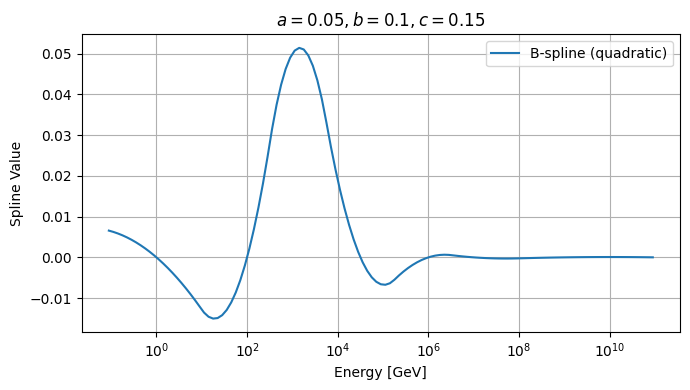

In [ ]:
mod_a  = bspline(E,0.,0.,0.,0.05,0.0,0., 0., 0., 0.)

# Plot
plt.figure(figsize=(7, 4))
plt.plot(E, y_spline, label='B-spline ')
#plt.scatter(10**x_knots, y_knots, color='red', label='Control Points')
plt.xscale('log')
plt.xlabel('Energy [GeV]')
plt.ylabel('Cross section modification factor')
plt.title('$a= 0.05, b=0.1, c=0.15$')
plt.grid(True)
plt.legend()
plt.tight_layout()


In [ ]:
# investigate cross section modification in MCEq

mod_factor = 